In [15]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [16]:
!pip install pymorphy3

In [17]:
!pip install wordcloud


ТОП-200 слов (релевантные части речи) по среднему TF-IDF:
работа: 0.0172
улица: 0.0160
проект: 0.0134
прессслужба: 0.0134
день: 0.0133
дом: 0.0131
человек: 0.0122
район: 0.0122
новый: 0.0121
пройти: 0.0119
сообщить: 0.0118
ребёнок: 0.0113
компания: 0.0110
ремонт: 0.0109
программа: 0.0108
центр: 0.0107
россия: 0.0102
данные: 0.0101
первый: 0.0100
тгу: 0.0098
время: 0.0097
получить: 0.0093
место: 0.0093
участок: 0.0091
рассказать: 0.0091
слово: 0.0091
школа: 0.0090
система: 0.0088
работать: 0.0082
фестиваль: 0.0081
региональный: 0.0079
вуз: 0.0078
летний: 0.0077
говориться: 0.0076
пожар: 0.0076
проспект: 0.0076
студент: 0.0075
участие: 0.0074
житель: 0.0072
мероприятие: 0.0072
участник: 0.0072
автомобиль: 0.0069
объект: 0.0069
уточнить: 0.0069
развитие: 0.0068
часть: 0.0067
сообщать: 0.0066
управление: 0.0066
принять: 0.0066
здание: 0.0066
должный: 0.0066
лесной: 0.0066
добавить: 0.0066
сообщить прессслужба: 0.0066
власть: 0.0065
движение: 0.0065
средство: 0.0064
рамка: 0.0063
составить

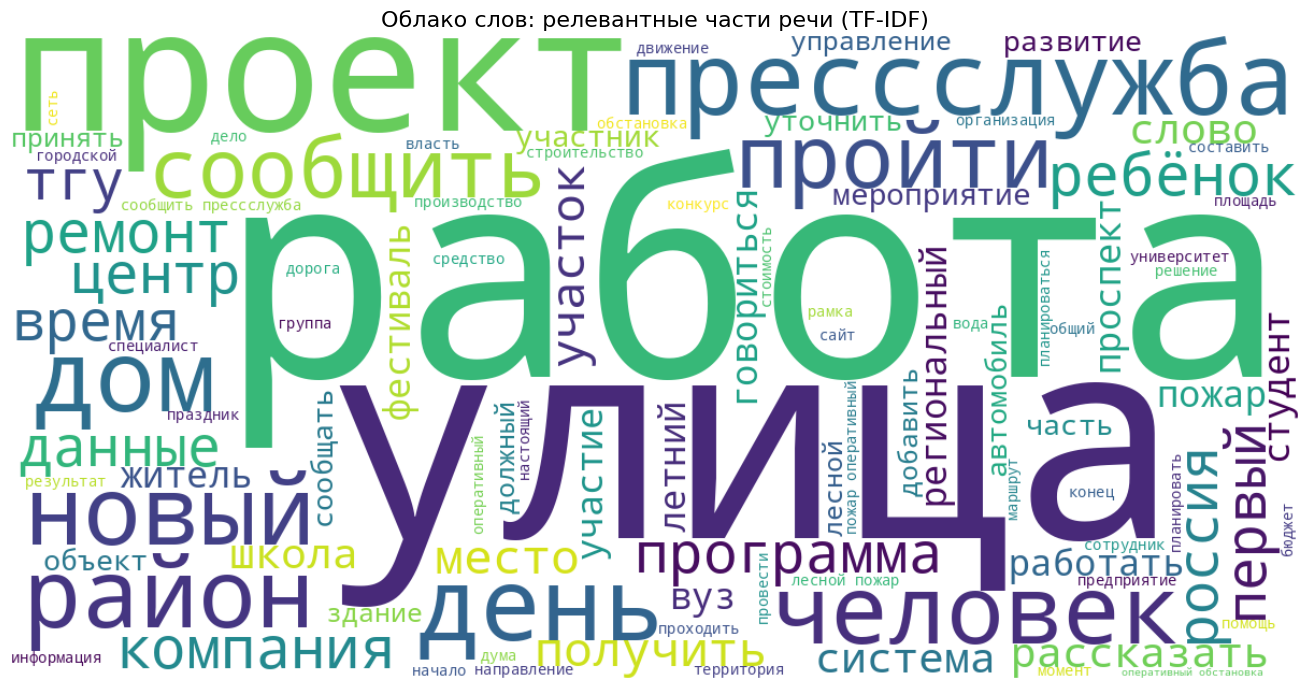

In [10]:
import pandas as pd
import re
import string
import numpy as np
import os

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import pymorphy3
from sklearn.feature_extraction.text import TfidfVectorizer

try:
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
except ImportError:
    WordCloud = None
df = pd.read_csv('/content/ria_tomsk_2025_news.csv', on_bad_lines='skip', encoding = 'utf-8')

df['document'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

morph = pymorphy3.MorphAnalyzer()
russian_stopwords = set(stopwords.words('russian'))
custom_stopwords = {'томск', 'весь', 'смочь', 'мочь', 'область', 'город', 'сообщаться', 'миллион', 'миллиард', 'число', 'рубль', 'тысяча', 'регион', 'изз', 'апр', 'зима', 'весна', 'осень', 'лето', 'год', 'снег', 'второй', 'четверг', 'пятница', 'суббота', 'понедельник', 'вторник', 'среда', 'томский', 'томич', 'год', 'года', 'это', 'который', 'также', 'такой', 'сказать', 'быть', 'стать', 'наш', 'наша', 'наше', 'наши', 'свой', 'свои', 'своя', 'риа', 'ооо', 'январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь'}
stopwords_set = russian_stopwords | custom_stopwords

spec_chars = string.punctuation + '«»—…\xa0\t\n'


RELEVANT_POS = {'NOUN', 'ADJF', 'ADJS', 'VERB', 'INFN', 'PRTF', 'PRTS', 'GRND'}

# Предобработка

UNIVERSITY_PHRASES = [
    ("томский политех", "томский_политех"),
    ("томский государственный университет", "тгу"),
    ("томский государственный", "тгу"),
    ("педагогический университет", "педуниверситет"),
    ("томский педагогический", "пед_университет"),
    ("томский пед", "томский_пед"),
    ("томский университет", "тгу"),
]

UNIVERSITY_KEYWORDS = {
    'тгу', 'тусур', 'политех', 'томский_политех', 'педуниверситет',
    'томский_пед', 'университет', 'вуз'
}

def normalize_university_names(text):
    if not isinstance(text, str):
        return text
    text = text.lower()
    for phrase, repl in UNIVERSITY_PHRASES:
        text = text.replace(phrase, repl)
    return text

def is_abbreviation(token):
    return (
        2 <= len(token) <= 6 and
        token.isupper() and
        all('А' <= ch <= 'Я' for ch in token)
    )

def preprocess_relevant_pos(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""

    text = normalize_university_names(text)

    original_tokens = word_tokenize(text, language='russian')

    text = ''.join(ch for ch in text if ch not in spec_chars)
    text = re.sub(r'\d+', ' ', text)
    text = text.lower()
    clean_tokens = word_tokenize(text, language='russian')

    lemmas_relevant = []
    for orig_tok, tok in zip(original_tokens, clean_tokens):
        if len(tok) < 2:
            continue

        if is_abbreviation(orig_tok):
            if tok not in stopwords_set:
                lemmas_relevant.append(tok)
            continue

        if tok in UNIVERSITY_KEYWORDS:
            lemmas_relevant.append(tok)
            continue

        parsed = morph.parse(tok)
        if parsed:
            lemma = parsed[0].normal_form
            pos = parsed[0].tag.POS

            if pos in RELEVANT_POS and lemma not in stopwords_set and len(lemma) > 2:
                lemmas_relevant.append(lemma)

    return ' '.join(lemmas_relevant)

df['cleaned'] = df['document'].apply(preprocess_relevant_pos)

df = df[df['cleaned'].str.strip() != ''].copy()

# TF-IDF векторизация

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9
)

X_tfidf = tfidf.fit_transform(df['cleaned'])
feature_names = tfidf.get_feature_names_out()

# Глобальный топ-200 слов по среднему TF-IDF

mean_tfidf = np.mean(X_tfidf.toarray(), axis=0)
top_indices = mean_tfidf.argsort()[-200:][::-1]

print("\nТОП-200 слов (релевантные части речи) по среднему TF-IDF:")
for i in top_indices:
    print(f"{feature_names[i]}: {mean_tfidf[i]:.4f}")

# Топ 15 слов для каждого документа

def get_top_tfidf_words_per_doc(tfidf_matrix, feature_names, df, top_n=15):
    results = []
    for idx in range(tfidf_matrix.shape[0]):
        scores = tfidf_matrix[idx].toarray().flatten()
        top_indices = scores.argsort()[-top_n:][::-1]
        top_words = [feature_names[i] for i in top_indices if scores[i] > 0]
        results.append({
            'doc_id': idx,
            'title': str(df.iloc[idx]['title'])[:80] + '...' if pd.notna(df.iloc[idx]['title']) else 'Без заголовка',
            'top_words': top_words
        })
    return results

top_words_all = get_top_tfidf_words_per_doc(X_tfidf, feature_names, df, top_n=15)

# Вывод по первым 10

print("ТОП-15 слов по TF-IDF для первых 10 новостей:")

for item in top_words_all[:10]:
    print(f"{item['title']}")
    print("→", ', '.join(item['top_words']))

# Облако слов

if WordCloud is not None:
    word_weights = dict(zip(feature_names, mean_tfidf))
    wordcloud = WordCloud(
        width=1200,
        height=600,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate_from_frequencies(word_weights)

    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Облако слов: релевантные части речи (TF-IDF)", fontsize=16)
    plt.tight_layout()
    plt.show()

# Сохраняемся
output_dir = "tfidf_results_relevant_pos"
os.makedirs(output_dir, exist_ok=True)

top200_data = [{"word": feature_names[i], "mean_tfidf": mean_tfidf[i]} for i in top_indices]
pd.DataFrame(top200_data).to_csv(
    os.path.join(output_dir, "top30_global.csv"), index=False, encoding='utf-8'
)

top_per_doc_df = pd.DataFrame(top_words_all)
top_per_doc_df['original_index'] = df.index[:len(top_per_doc_df)].tolist()
top_per_doc_df.to_csv(
    os.path.join(output_dir, "top_words_per_document.csv"), index=False, encoding='utf-8'
)

np.savez_compressed(
    os.path.join(output_dir, "tfidf_data.npz"),
    tfidf_matrix=X_tfidf.toarray(),
    feature_names=feature_names,
    original_indices=df.index.values
)

if WordCloud is not None:
    cloud_path = os.path.join(output_dir, "wordcloud_relevant_pos.png")
    wordcloud.to_file(cloud_path)

# Тоже самое, но только для существительных


ТОП-200 существительных по среднему TF-IDF:
работа: 0.0204
прессслужба: 0.0159
проект: 0.0158
день: 0.0155
дом: 0.0155
человек: 0.0146
район: 0.0144
ребёнок: 0.0133
ремонт: 0.0132
компания: 0.0129
программа: 0.0128
центр: 0.0127
данные: 0.0119
россия: 0.0118
время: 0.0116
участок: 0.0111
место: 0.0109
пожар: 0.0106
слово: 0.0106
школа: 0.0106
система: 0.0103
фестиваль: 0.0092
проспект: 0.0091
вуз: 0.0090
пожар обстановка: 0.0087
студент: 0.0086
участие: 0.0086
обстановка: 0.0085
житель: 0.0084
автомобиль: 0.0083
мероприятие: 0.0083
участник: 0.0083
объект: 0.0082
часть: 0.0080
развитие: 0.0080
движение: 0.0078
здание: 0.0078
управление: 0.0078
власть: 0.0076
средство: 0.0075
рамка: 0.0074
специалист: 0.0074
университет: 0.0074
решение: 0.0073
площадь: 0.0072
конкурс: 0.0072
информация: 0.0071
помощь: 0.0071
дорога: 0.0071
сеть: 0.0071
дело: 0.0071
начало: 0.0069
строительство: 0.0069
праздник: 0.0069
территория: 0.0068
организация: 0.0068
дума: 0.0067
направление: 0.0066
тусура: 0.006

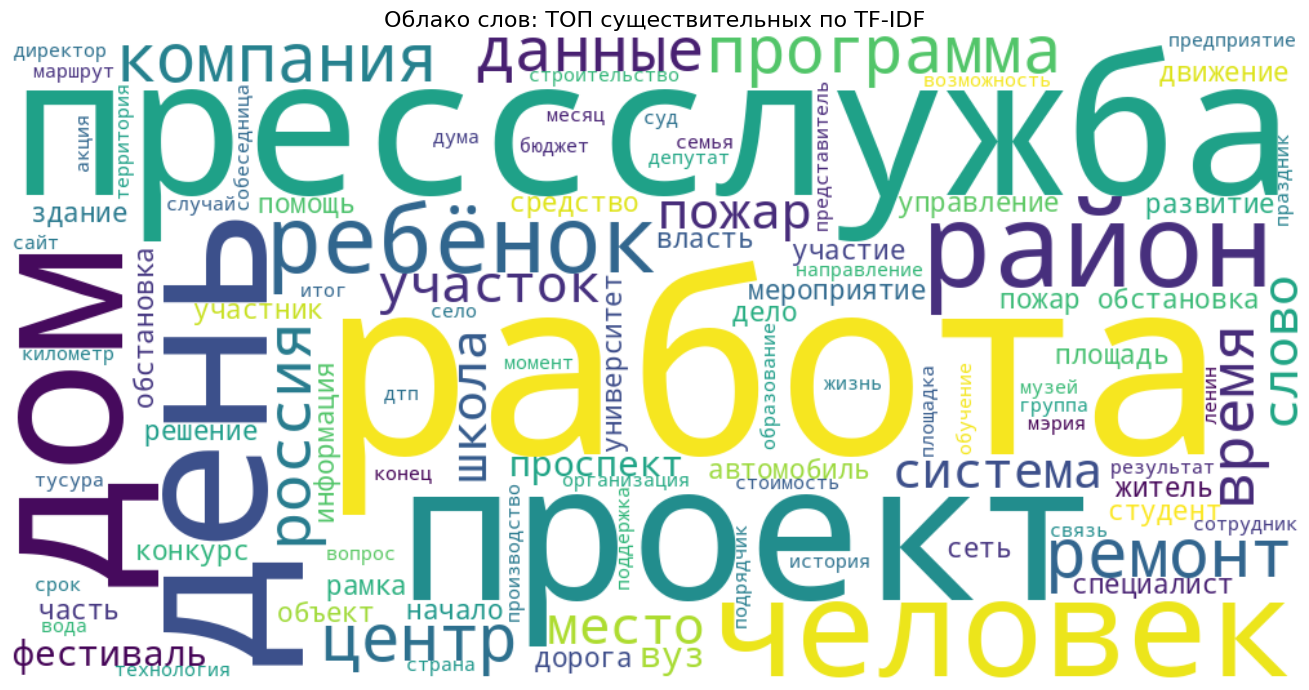

In [21]:
import pandas as pd
import re
import string
import numpy as np
from collections import Counter

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import pymorphy3
from sklearn.feature_extraction.text import TfidfVectorizer

russian_stopwords = set(stopwords.words('russian'))

try:
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
except ImportError:
    WordCloud = None

df = pd.read_csv('/content/ria_tomsk_2025_news.csv')

df['document'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

morph = pymorphy3.MorphAnalyzer()
custom_stopwords = {'томск', 'весь', 'смочь', 'мочь', 'область', 'город', 'улица', 'час', 'сообщаться', 'миллион', 'миллиард', 'число', 'рубль', 'тысяча', 'регион', 'изз', 'апр', 'зима', 'весна', 'осень', 'лето', 'год', 'снег', 'второй', 'четверг', 'пятница', 'суббота', 'понедельник', 'вторник', 'среда', 'томский', 'томич', 'год', 'года', 'это', 'который', 'также', 'такой', 'сказать', 'быть', 'стать', 'наш', 'наша', 'наше', 'наши', 'свой', 'свои', 'своя', 'риа', 'ооо', 'январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь'}
stopwords_set = russian_stopwords | custom_stopwords

spec_chars = string.punctuation + '«»—…\xa0\t\n'

UNIVERSITY_PHRASES = [
    ("томский политех", "томский_политех"),
    ("томский государственный университет", "тгу"),
    ("педагогический университет", "педуниверситет", "пед университет"),
    ("томский педагогический", "томский_пед"),
]

def normalize_phrases(text):
    if not isinstance(text, str):
        return text
    text = text.lower()
    for phrase, repl in UNIVERSITY_PHRASES:
        text = text.replace(phrase, repl)
    return text

def preprocess_nouns_only(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""

    original_tokens = word_tokenize(text, language='russian')

    text = ''.join(ch for ch in text if ch not in spec_chars)
    text = re.sub(r'\d+', ' ', text)
    text = text.lower()
    clean_tokens = word_tokenize(text, language='russian')

    lemmas_nouns = []
    for orig_tok, tok in zip(original_tokens, clean_tokens):
        if len(tok) < 2:
            continue

        if is_abbreviation(orig_tok):
            if tok not in stopwords_set:
                lemmas_nouns.append(tok)
            continue

        if tok in UNIVERSITY_PHRASES:
            if tok not in stopwords_set:
                lemmas_nouns.append(tok)
            continue

        parsed = morph.parse(tok)
        if parsed:
            lemma = parsed[0].normal_form
            pos = parsed[0].tag.POS

            if pos == 'NOUN' and lemma not in stopwords_set and len(lemma) > 2:
                lemmas_nouns.append(lemma)

    return ' '.join(lemmas_nouns)

df['cleaned'] = df['document'].apply(preprocess_nouns_only)

df = df[df['cleaned'].str.strip() != ''].copy()

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9
)

X_tfidf = tfidf.fit_transform(df['cleaned'])
feature_names = tfidf.get_feature_names_out()

mean_tfidf = np.mean(X_tfidf.toarray(), axis=0)
top_indices = mean_tfidf.argsort()[-200:][::-1]

print("\nТОП-200 существительных по среднему TF-IDF:")
for i in top_indices:
    print(f"{feature_names[i]}: {mean_tfidf[i]:.4f}")

def get_top_tfidf_words_per_doc(tfidf_matrix, feature_names, df, top_n=15):
    results = []
    for idx in range(tfidf_matrix.shape[0]):
        scores = tfidf_matrix[idx].toarray().flatten()
        top_indices = scores.argsort()[-top_n:][::-1]
        top_words = [feature_names[i] for i in top_indices if scores[i] > 0]
        results.append({
            'doc_id': idx,
            'title': str(df.iloc[idx]['title'])[:80] + '...' if pd.notna(df.iloc[idx]['title']) else 'Без заголовка',
            'top_words': top_words
        })
    return results

top_words_all = get_top_tfidf_words_per_doc(X_tfidf, feature_names, df, top_n=15)

# Вывод для первых 10 документов

print("ТОП-5 существительных по TF-IDF для первых 10 новостей:")

for item in top_words_all[:10]:
    print(f"{item['title']}")
    print("→", ', '.join(item['top_words']))

if WordCloud is not None:
    word_weights = dict(zip(feature_names, mean_tfidf))
    wordcloud = WordCloud(
        width=1000,
        height=500,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate_from_frequencies(word_weights)

    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Облако слов: ТОП существительных по TF-IDF", fontsize=16)
    plt.tight_layout()
    plt.show()

In [24]:
import os

output_dir = "tfidf_results_nouns"
os.makedirs(output_dir, exist_ok=True)

top200_data = [{"word": feature_names[i], "mean_tfidf": mean_tfidf[i]} for i in top_indices]
top200_df = pd.DataFrame(top200_data)
top200_df.to_csv(os.path.join(output_dir, "top200_global.csv"), index=False, encoding='utf-8')

top_per_doc_df = pd.DataFrame(top_words_all)

if 'url' in df.columns:
    top_per_doc_df['url'] = df.iloc[:len(top_per_doc_df)]['url'].values
if 'id' in df.columns:
    top_per_doc_df['id'] = df.iloc[:len(top_per_doc_df)]['id'].values

top_per_doc_df.to_csv(os.path.join(output_dir, "top_words_per_document.csv"), index=False, encoding='utf-8')

np.savez_compressed(
    os.path.join(output_dir, "tfidf_data.npz"),
    tfidf_matrix=X_tfidf.toarray(),
    feature_names=feature_names,
    doc_ids=df.index.values
)

if WordCloud is not None:
    word_weights = dict(zip(feature_names, mean_tfidf))
    wordcloud = WordCloud(
        width=1200,
        height=600,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate_from_frequencies(word_weights)

    cloud_path = os.path.join(output_dir, "wordcloud_tfidf_nouns.png")
    wordcloud.to_file(cloud_path)